In [1]:
import pandas as pd
pd.set_option('display.max_rows',500)
import numpy as np
from pymongo import MongoClient, UpdateOne
from datetime import datetime, timedelta
import glob, os, shutil
import time

In [2]:
import matplotlib.pyplot as plt

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By

### MongoDB Conexion

In [4]:
conn = MongoClient("localhost:27017")
db = conn.get_database("expenses_control")

In [5]:
move = db.get_collection('movements')
cate = db.get_collection('categories')
subcate = db.get_collection('subcategories')

In [6]:
def insert_object(df, collection):
    '''
    This function inserts all the information from the dataframe we created with the previous function as a Mongodb object.
    This object will have two field: title (name of the film or show) and reviews (array with all the reviews users have made)
    '''

    collection.insert_many(df.to_dict('records'))

In [7]:
def remove_docs(collection):
    return collection.remove({})

In [8]:
def collection_to_pd(collection):
    return pd.DataFrame(list(collection.find({},{'_id':0})))

In [9]:
def insert_single_object(collection):
    date = datetime.now().strftime("%d/%m/%Y")
    description = str(input('Describe the money flow briefly:'))
    quantity = float(input('Insert the correcto amount rounded to two decimal numbers:'))
    category = input('To what category does the movement belong?')
    return collection.insert_one({'date':date,
                            'description':description,
                            'quantity':quantity,
                            'category':category})

### Downloading and preparing bank data

In [10]:
USERNAME = 'jpello6'
PASSWORD = 'fapell6'

In [11]:
def data_extraction():
    
    os.environ['WDM_LOG_LEVEL'] = '0'
    browser = webdriver.Chrome(ChromeDriverManager().install())
    wait = WebDriverWait(browser, 10)
    browser.maximize_window()
    browser.get("https://bancaonline.bankinter.com/gestion/login.xhtml")
    browser.implicitly_wait(5)
    browser.find_element_by_xpath("//a[contains(text(),'aceptar')]").click()
 
    username = browser.find_element_by_name("uid")
    password = browser.find_element_by_name("password")
    
    username.send_keys(USERNAME)
    password.send_keys(PASSWORD)
    browser.find_element_by_id("btEntrar").click()
    browser.implicitly_wait(5)
    
    charges = wait.until(ec.element_to_be_clickable((By.XPATH, '/html/body/main/div/div/section/div[1]/form[1]/section/div/div[7]/div[1]/div[2]/div[3]/ul/li[1]')))
    charges.click()
    
    download_charges_excel = wait.until(ec.element_to_be_clickable((By.XPATH, '//html/body/main/section/form/div[1]/span[4]/div/ul/li[1]/a')))
    download_charges_excel.click()                                                                           
    
    return_home = wait.until(ec.element_to_be_clickable((By.XPATH, '//*[@id="menuCabecera"]/li[1]/a')))
    return_home.click()
    
    incomes = wait.until(ec.element_to_be_clickable((By.XPATH, '/html/body/main/div/div/section/div[1]/form[1]/section/div/div[1]/div[1]/div[2]/div[3]/ul/li[1]')))
    incomes.click()
    
    download_incomes_excel = wait.until(ec.element_to_be_clickable((By.XPATH, '/html/body/main/section/div[1]/span[1]/div[1]/form/ul/li[1]/a')))
    download_incomes_excel.click()

    
    time.sleep(5)

    browser.close()

In [12]:
def move_file():
    incomes_file = 'C:\\Users\\juanp\\Downloads\\movimientos.xls'
    charges_file = 'C:\\Users\\juanp\\Downloads\\Movimientos (1).xls'
    destination = 'C:\\Users\\juanp\\proyectos_varios\\expenses_control\\data'
    
    try:
        shutil.move(charges_file,destination)
        shutil.move(incomes_file, destination)
    except: 
        pass
    try:
        os.replace(charges_file, destination)
        os.replace(incomes_file, destination)
    except:
        pass

### Categorization lists

In [15]:
categories = [food_and_drinks,shopping, transport, cash_out, travel, other_activities, cash_in, subscriptions]

In [16]:
subcategories = [supermarkets, clothing, sports, other_shopping, restaurants, food, drinks_and_clubs, taxi,
                 car_sharing, bus_metro, car, plane, other_transport, parking, accomodation, leisure, sports, penalty_fee, 
                savings, money_extraction, salary, other_expenses, academic]

In [10]:
def categorization(value):
    for number in range(0, len(categories)):
        for element in categories[number]:
            if element.lower() in value.lower():
                return categories[number][-1]
            else:
                pass

In [11]:
def subcategorization(value):
    for number in range(0, len(subcategories)):
        for element in subcategories[number]:
            if element.lower() in value.lower():
                return subcategories[number][-1]
            else:
                pass

In [12]:
def bizum_categorization():
    date = str(input())
    name = str(input())
    qty = float(input())
    category = str(input())
    subcategory = str(input())
    return move.update_one({'description':{'$regex':name},'date':date,
                                  'quantity':qty},{'$set':{'category':category, 'subcategory': subcategory}})
    

In [13]:
def data_insert(path_charges, path_incomes, collection):
    
    incomes = pd.read_excel(path_incomes)[3:]
    incomes.drop(['Unnamed: 1', 'Unnamed: 4'], axis = 1, inplace=True)
    incomes.rename(columns={'IBAN: ES6701280067740100026987':'date', 'Unnamed: 2':'description', 
                            'Unnamed: 3':'quantity'}, inplace=True)
    
    charges = pd.read_excel(path_charges)
    list_index = charges.index[charges["Número de tarjeta: Visa Clasi (....2133)"]=='Total Crédito'].tolist()
    for number in list_index:
        limit_index = number
    charges = charges[5:limit_index]
    charges.drop(['Unnamed: 2'], axis = 1, inplace=True)
    charges.rename(columns={'Número de tarjeta: Visa Clasi (....2133)':'date', 'Unnamed: 1':'description', 
                            'Unnamed: 3':'quantity'}, inplace=True)
    charges['date'] = charges['date'].apply(lambda x: x.strftime('%d/%m/%Y'))
    
    complete = pd.concat([incomes, charges])
    
    current_month = datetime.today().date().replace(day=1).strftime('%m/%Y')
    first_day_prev_month = datetime.today().replace(day=1) - timedelta(days=1)
    prev_month = first_day_prev_month.strftime('%m/%Y')
    complete.drop(complete[complete.description == 'RECIBO VISA CLASICA'].index, inplace = True)
    
    old = pd.DataFrame(list(move.find({'date':{'$regex':current_month}},{'_id':0,'category':0})))
    
    complete_up = complete.loc[complete['date'].str.contains(current_month)]
    final_df = pd.concat([old, complete_up])
    final_df.drop_duplicates(keep = False, inplace = True)
    final_df['category'] = list(map(categorization, final_df['description']))
    final_df['subcategory'] = list(map(subcategorization, final_df['description']))
    os.remove('data\\movimientos.xls')
    os.remove('data\\Movimientos (1).xls')
    
    option = input('What action do you want to take? - update or insert').lower()
        
    if option == 'insert':
        insert_object(complete, move)
        return 'Data succesfully inserted'

    elif option == 'update':
        if len(final_df) == 0:
            return 'Nothing to update'
        else:
            insert_object(final_df, move)
            ##insert_object(final_df, move)
            return 'Data succesfully updated'

In [21]:
def my_bank_movements():
    
    try:
    
        data_extraction()
        
    except:
        
        return 'There has been a problem with the conexion. Please, try again later'
    
    move_file()

    return data_insert('data\\movimientos.xls', 'data\\Movimientos (1).xls', move)
    

In [14]:
df = collection_to_pd(move)

### Visualization

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
category_name = ['food_and_drinks','shopping', 'transport', 'cash_out', 'travel',
                 'other_activities', 'cash_in', 'subscriptions']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']


In [180]:
def visualization(): 
    
    plot = input('What graph do you want to display?')
    
    if plot == 'Categories':
        
        fig1, ax1 = plt.subplots()

        ax1.pie(categories_count, labels = category_name, colors = colors, autopct='%1.1f%%', startangle=90,
               pctdistance=0.85)

        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.set_size_inches(9,9)
        fig.gca().add_artist(centre_circle)

        ax1.axis('equal')  
        plt.tight_layout()
        plt.show()
        
    elif plot == 'Subcategories':
        
        fig1, ax1 = plt.subplots()

        ax1.pie(subcategories_count, labels = subcategory_name, colors = colors, autopct='%1.1f%%', startangle=90,
               pctdistance=0.85)

        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.set_size_inches(9,9)
        fig.gca().add_artist(centre_circle)

        ax1.axis('equal')  
        plt.tight_layout()
        plt.show()
        

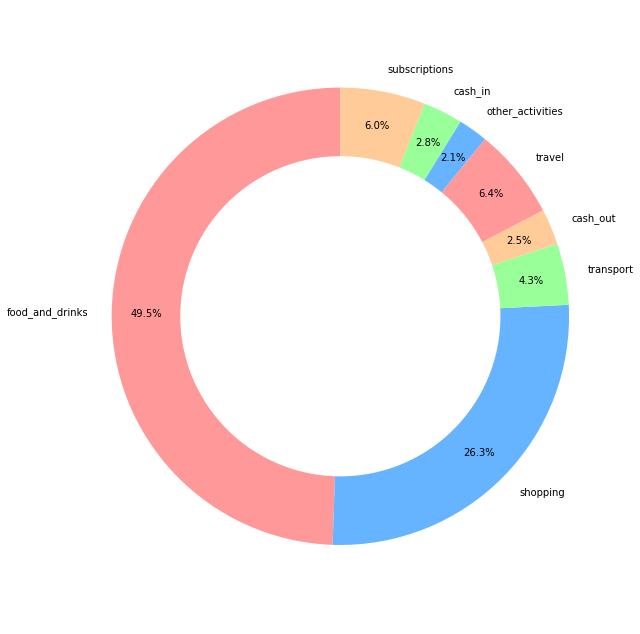

In [149]:
fig1, ax1 = plt.subplots()

ax1.pie(t, labels = category_name, colors = colors, autopct='%1.1f%%', startangle=90,
       pctdistance=0.85)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.set_size_inches(9,9)
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [67]:
df.shape

(383, 5)